<a href="https://colab.research.google.com/github/ZYM-ai/DNN_classification_gpu/blob/master/Dnn_on_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch 
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [0]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [4]:
len(dataset)

60000

In [0]:
def split_indices(n, val_pct):
  n_val = int(n*val_pct)
  idxs = np.random.permutation(n)
  return idxs[n_val:], idxs[:n_val]

In [9]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

len(train_indices)

48000

In [0]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

In [0]:
import torch.nn.functional as F
import torch.nn as nn

In [0]:
class MnistModel(nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)

    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    return out

In [0]:
input_size = 784
num_classes = 10

model = MnistModel(input_size,  hidden_size=32, out_size=num_classes)

In [17]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [32]:
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('loss:', loss.data)
  break
print('outputs.shape:', outputs.shape)
print('sampler outputs:\n', outputs[:2].data)

loss: tensor(2.2829)
outputs.shape: torch.Size([100, 10])
sampler outputs:
 tensor([[ 0.1414,  0.0022, -0.0177,  0.0151, -0.2444, -0.0688,  0.0359,  0.0601,
          0.1075,  0.1151],
        [ 0.1065,  0.0631,  0.0877, -0.0696, -0.2404, -0.1159,  0.0212,  0.0750,
          0.0859,  0.0555]])


In [33]:
torch.cuda.is_available()

False

In [35]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_default_device()
device

device(type='cpu')

In [0]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  

In [37]:
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([100, 1, 28, 28])
cpu


In [0]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [0]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

In [44]:
for xb, yb in valid_dl:
  print('xb.device:', xb.device)
  print('yb:', yb)
  break

xb.device: cpu
yb: tensor([2, 1, 3, 1, 5, 7, 4, 4, 4, 9, 5, 6, 1, 8, 9, 1, 2, 4, 2, 3, 5, 7, 9, 3,
        7, 6, 9, 4, 5, 7, 0, 4, 7, 7, 1, 8, 3, 9, 7, 3, 1, 6, 3, 3, 1, 0, 4, 2,
        6, 7, 6, 8, 6, 8, 2, 5, 5, 7, 1, 4, 5, 7, 8, 4, 8, 6, 4, 3, 0, 0, 2, 8,
        8, 2, 4, 9, 4, 9, 2, 3, 0, 5, 3, 5, 6, 0, 2, 0, 9, 4, 5, 9, 2, 9, 1, 1,
        1, 0, 5, 9])


In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
  preds = model(xb)
  loss = loss_func(preds, yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  metric_result = None
  if metric is not None:
    metric_result = metric(preds, yb)
  return loss.item(), len(xb), metric_result

In [0]:
def evaluate(model, loss_fn, valid_dl, metric=None):
  with torch.no_grad():
    results = [loss_batch(model, loss_fn, xb, yb, metric=metric) 
              for xb, yb in valid_dl]
    losses, nums, metrics = zip(*results)

    total = np.sum(nums)
    avg_loss = np.sum(np.multiply(losses, nums))/total
    avg_metric = None
    if metric is not None:
      avg_metric = np.sum(np.multiply(metrics, nums))/total
  return avg_loss, total, avg_metric

In [0]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric=None, opt_fn=None):
  losses, metrics = [], []

  if opt_fn is None: opt_fn = torch.optim.SGD
  opt = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(epochs):
    for xb, yb in train_dl:
      loss,_,_ = loss_batch(model,loss_fn, xb, yb, opt)
    
    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_metric = result

    losses.append(val_loss)
    metrics.append(val_metric)

    if metric is None:
      print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1, epochs, val_loss))

    else:
      print('epoch [{}/{}], loss: {:.4f}, {}, {:.4f}'.format(epoch+1, epochs, val_loss,
                                                             metric.__name__, val_metric))
  return losses, metrics

In [0]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == labels).item()/len(preds)

In [49]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [53]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy, valid_dl, metric=accuracy)
print('loss: {:.4f}, accuracy: {:.4f}'.format(val_loss, val_acc))

loss: 2.3114, accuracy: 0.0681


In [54]:
losses1, metrics1 = fit(5, 0.5, model, F.cross_entropy, train_dl, valid_dl, accuracy)

epoch [1/5], loss: 0.2142, accuracy, 0.9367
epoch [2/5], loss: 0.1800, accuracy, 0.9483
epoch [3/5], loss: 0.1758, accuracy, 0.9497
epoch [4/5], loss: 0.1499, accuracy, 0.9564
epoch [5/5], loss: 0.1279, accuracy, 0.9642


In [56]:
losses2, metrics2 = fit(5, 0.5, model, F.cross_entropy, train_dl, valid_dl, accuracy)

epoch [1/5], loss: 0.1315, accuracy, 0.9614
epoch [2/5], loss: 0.1223, accuracy, 0.9667
epoch [3/5], loss: 0.1312, accuracy, 0.9633
epoch [4/5], loss: 0.1333, accuracy, 0.9634
epoch [5/5], loss: 0.1268, accuracy, 0.9653


In [0]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'accuracy vs. No. of epochs')

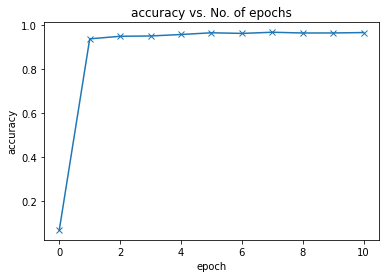

In [59]:
accuracies = [val_acc] + metrics1+ metrics2
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs')

In [61]:
pip install jovian --upgrade -q

     |████████████████████████████████| 92kB 3.5MB/s 
